# 用LSTM预测股票行情

这里采用沪深300指数数据，时间跨度是2010年10月10号至今，选择每天的最高价格。假设当天最高价依赖当天的前n（如30）天的沪深300的最高价格。用LSTM模型来捕捉最高价的时序信息，通过模型训练，使之学会用前n天的最高价，来判断当天的最高价。

## 导入数据

这里使用tushare来下载沪深300指数数据。

In [1]:
import tushare as ts

In [2]:
cons=ts.get_apis()

In [3]:
#获取沪深指数(000300)的信息，包括交易日期（datetime）、开盘价(open)、收盘价(close)，
#最高价(high)、最低价(low)、成交量(vol)、成交金额(amount)、涨跌幅(p_change)
df = ts.bar('000300', conn=cons, asset='INDEX', start_date='2010-01-01', end_date='')

In [4]:
#去除有null的行，并保存数据
df=df.dropna()
df=df[::-1]
df.head()
df.to_csv('sh300.csv')

## 数据预览

查看下载的数据字段，统计信息等

In [5]:
#查看df涉及的列名
df.columns

Index(['code', 'open', 'close', 'high', 'low', 'vol', 'amount', 'p_change'], dtype='object')

In [6]:
#数据预览
df.describe()

,open,close,high,low,vol,amount,p_change
count,2498.000000,2498.000000,2498.000000,2498.000000,2.498000e+03,2.498000e+03,2498.000000
mean,3164.699071,3167.385717,3192.246113,3138.031313,1.097027e+06,1.329445e+11,0.013703
std,640.600627,640.784471,646.695358,632.215121,8.978497e+05,1.233583e+11,1.468988
min,2079.870000,2086.970000,2118.790000,2023.170000,2.190120e+05,2.120044e+10,-8.750000
25%,2575.430000,2575.267500,2600.192500,2553.830000,5.853520e+05,6.294749e+10,-0.640000
50%,3211.400000,3215.995000,3240.580000,3183.255000,8.334245e+05,9.758049e+10,0.020000
75%,3651.845000,3666.522500,3694.032500,3630.220000,1.222776e+06,1.458162e+11,0.700000
max,5379.470000,5353.750000,5380.430000,5283.090000,6.864391e+06,9.494980e+11,6.710000


由上图可知，共有2495条数据。

## 数据预处理及可视化最高价数据。

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

%matplotlib inline

接下来，生成训练数据：

In [8]:
#通过一个序列来生成一个31*(count(*)-train_end)矩阵（用于处理时序的数据）
#其中最后一列维标签数据。就是把当天的前n天作为参数，当天的数据作为label
def generate_data_by_n_days(series, n, index=False):
    if len(series) <= n:
        raise Exception("The Length of series is %d, while affect by (n=%d)." % (len(series), n))
    df = pd.DataFrame()
    for i in range(n):
        df['c%d' % i] = series.tolist()[i:-(n - i)]        
    df['y'] = series.tolist()[n:]
    
    if index:
        df.index = series.index[n:]
    return df

#参数n与上相同。train_end表示的是后面多少个数据作为测试集。
def readData(column='high', n=30, all_too=True, index=False, train_end=-500):
    df = pd.read_csv("sh300.csv", index_col=0)
    #以日期为索引
    df.index = list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), df.index))
    #获取每天的最高价
    df_column = df[column].copy()
    #拆分为训练集和测试集
    df_column_train, df_column_test = df_column[:train_end], df_column[train_end - n:]
    #生成训练数据
    df_generate_train = generate_data_by_n_days(df_column_train, n, index=index)
    if all_too:
        return df_generate_train, df_column, df.index.tolist()
    return df_generate_train


In [9]:
n = 30
LR = 0.001
EPOCH = 200
batch_size=20
train_end =-600

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

接下来，可视化最高价数据。

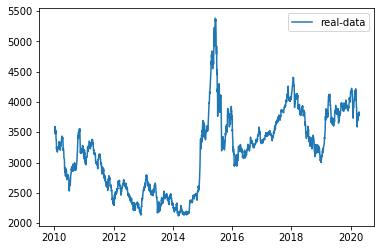

In [10]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#获取训练数据，原始数据，索引信息等
df,df_all,df_index=readData('high',n=n,train_end=train_end)

#可视化最高价
df_all=np.array(df_all.tolist())
plt.plot(df_index,df_all,label='real-data')
plt.legend(loc='upper right')

## 定义模型及训练

定义模型如下：这里使用LSTM网络，此时LSTM输出到一个全连接层。

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=64,
            num_layers=1,
            batch_first=True
        )
        self.out = nn.Sequential(
            nn.Linear(64, 1)
        )

    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)  #None即隐层状态用0初始化
        out = self.out(r_out)
        return out


class mytrainset(Dataset):
    def __init__(self, data):        
        self.data, self.label = data[:, :-1].float(), data[:, -1].float()
             
    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)


训练模型，并对数据进行规范化转为Tensor

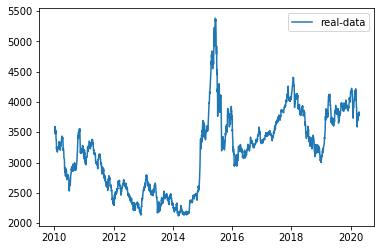

In [12]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# 获取训练数据、原始数据、索引等信息
df, df_all, df_index = readData('high', n=n, train_end=train_end)

#可视化原高价数据
df_all = np.array(df_all.tolist())
plt.plot(df_index, df_all, label='real-data')
plt.legend(loc='upper right')  


#对数据进行预处理，规范化及转换为Tensor
df_numpy = np.array(df)

df_numpy_mean = np.mean(df_numpy)
df_numpy_std = np.std(df_numpy)

df_numpy = (df_numpy - df_numpy_mean) / df_numpy_std
df_tensor = torch.Tensor(df_numpy)


trainset = mytrainset(df_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False)

In [13]:
#记录损失值，并用tensorboardx在web上展示
from tensorboardX import SummaryWriter
writer = SummaryWriter(log_dir='logs')

rnn = RNN(n).to(device)
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)  
loss_func = nn.MSELoss()

for step in range(EPOCH):
    for tx, ty in trainloader:
        tx=tx.to(device)
        ty=ty.to(device)
        #在第1个维度上添加一个维度为1的维度，形状变为[batch,seq_len,input_size]
        output = rnn(torch.unsqueeze(tx, dim=1)).to(device)
        loss = loss_func(torch.squeeze(output), ty)
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()
    writer.add_scalar('sh300_loss', loss, step)  

## 测试模型

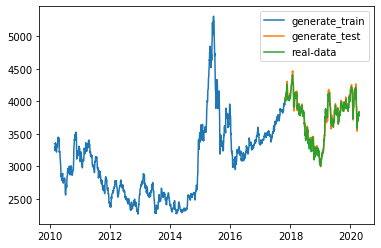

In [14]:
generate_data_train = []
generate_data_test = []

test_index = len(df_all) + train_end

df_all_normal = (df_all - df_numpy_mean) / df_numpy_std
df_all_normal_tensor = torch.Tensor(df_all_normal)
for i in range(n, len(df_all)):
    x = df_all_normal_tensor[i - n:i].to(device)
    #rnn的输入必须是3维，故需添加两个1维的维度，最后成为[1,1,input_size]
    x = torch.unsqueeze(torch.unsqueeze(x, dim=0), dim=0)
    
    y = rnn(x).to(device)
    if i < test_index:
        generate_data_train.append(torch.squeeze(y).detach().cpu().numpy() * df_numpy_std + df_numpy_mean)
    else:
        generate_data_test.append(torch.squeeze(y).detach().cpu().numpy() * df_numpy_std + df_numpy_mean)
plt.plot(df_index[n:train_end], generate_data_train, label='generate_train')
plt.plot(df_index[train_end:], generate_data_test, label='generate_test')
plt.plot(df_index[train_end:], df_all[train_end:], label='real-data')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

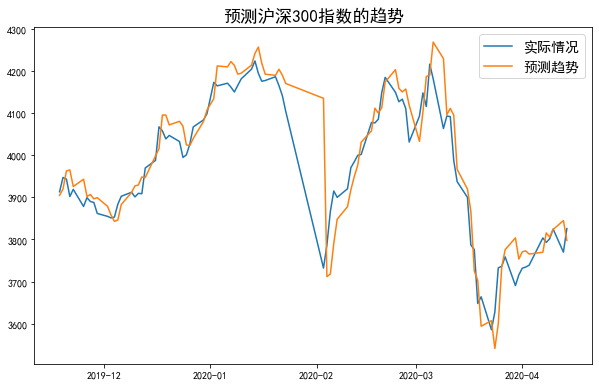

In [39]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.clf()
plt.figure(figsize=(10, 6.2))
plt.plot(df_index[-100:-1], df_all[-100:-1], label='实际情况')
plt.plot(df_index[-100:-1], generate_data_test[-100:-1], label='预测趋势')
plt.legend(fontsize=14)
plt.title('预测沪深300指数的趋势',fontsize='xx-large',fontweight='heavy')
plt.show()

从上图来看，预测结果还是不错的。